In [1]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
import torch
import numpy as np
from torch.utils.data import DataLoader

from model import MixingModel
from dataset import AudioMixingDataset
from inference_utils import mix_song

%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Torch version: ', torch.__version__)
print('Device: ', device)

print(torch.backends.cudnn.version())
torch.backends.cudnn.benchmark = True

Torch version:  1.4.0
Device:  cuda
7603


In [3]:
base_path = '/media/apelykh/bottomless-pit/datasets/mixing/MUSDB18HQ'
weights_dir = './weights'
seed = 321
chunk_length = 5

In [4]:
d_train = AudioMixingDataset(os.path.join(base_path, 'train'),
                             chunk_length=chunk_length, train_val_test_split=(0.95, 0.0, 0.0),
                             mode='train', seed=seed)

d_val = AudioMixingDataset(os.path.join(base_path, 'train'),
                             chunk_length=chunk_length, train_val_test_split=(0.0, 0.05, 0.0),
                             mode='val', seed=seed)

d_test = AudioMixingDataset(os.path.join(base_path, 'test'),
                             chunk_length=chunk_length, train_val_test_split=(0.0, 0.0, 1.0),
                             mode='test', seed=seed)

print('Train: {} tracks, {} chunks'.format(d_train.get_num_songs(), len(d_train)))
print('Val: {} tracks, {} chunks'.format(d_val.get_num_songs(), len(d_val)))
print('Test: {} tracks, {} chunks'.format(d_test.get_num_songs(), len(d_test)))

Train: 95 tracks, 4371 chunks
Val: 5 tracks, 271 chunks
Test: 50 tracks, 2473 chunks


(4, 128, 216)
145.5986 151.05945
[[148.74838 148.59888 148.02077 ... 147.36417 146.9565  148.10765]
 [149.01851 149.72015 148.97699 ... 148.25977 148.15175 148.95691]
 [150.02388 149.98317 149.42076 ... 148.81207 148.71077 148.98297]
 ...
 [145.5986  145.5986  145.5986  ... 145.5986  145.5986  145.5986 ]
 [145.5986  145.5986  145.5986  ... 145.5986  145.5986  145.5986 ]
 [145.5986  145.5986  145.5986  ... 145.5986  145.5986  145.5986 ]]
(128, 216)
------------------------------------------------------------
23.221737 24.630726
[[24.5678   24.472366 24.440544 ... 23.772764 23.50341  23.656622]
 [24.358347 24.53083  24.38118  ... 24.105265 24.041708 24.063963]
 [23.984303 24.285543 24.078934 ... 23.949482 23.954533 23.957983]
 ...
 [23.221737 23.221737 23.221737 ... 23.221737 23.221737 23.221737]
 [23.221737 23.221737 23.221737 ... 23.221737 23.221737 23.221737]
 [23.221737 23.221737 23.221737 ... 23.221737 23.221737 23.221737]]
(128, 216)


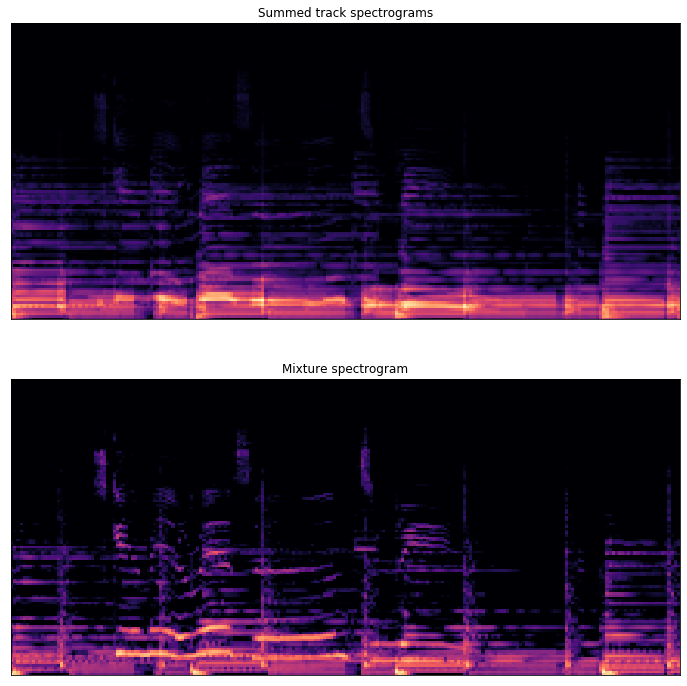

In [5]:
plt.figure(figsize=(12, 12))

sample = d_val[10]
# ipd.Audio(d[1103]['drums_audio'], rate=44100)

print(sample['train_features'].shape)

summed_spec = sample['train_features'].sum(axis=0)

print(np.min(summed_spec), np.max(summed_spec))
print(summed_spec)

print(summed_spec.shape)
ax1 = plt.subplot(2,1,1)
librosa.display.specshow(summed_spec)
plt.title('Summed track spectrograms')

# -----------------------------------------------------------------
print('-' * 60)

print(np.min(sample['gt_features']), np.max(sample['gt_features']))
print(sample['gt_features'])

print(sample['gt_features'].shape)
ax2 = plt.subplot(2,1,2, sharex=ax1)
librosa.display.specshow(sample['gt_features'])
plt.title('Mixture spectrogram')

plt.show()

In [ ]:
for i in range(len(d)):
    print('CHUNK: {}'.format(i))
    print('---------------')
    sample = d[i]
    if i == 20:
#         print(sample['drums_feature'].shape)
#         librosa.display.specshow(sample['mixture_feature'])
        ipd.Audio(sample['drums_audio'], rate=44100)
        print('---------------')
        break

In [5]:
train_loader = DataLoader(d_train, batch_size=32, shuffle=False,
                          num_workers=0, collate_fn=None,
                          pin_memory=False, drop_last=False, timeout=0,
                          worker_init_fn=None)

val_loader = DataLoader(d_val, batch_size=136, shuffle=False,
                        num_workers=0, collate_fn=None,
                        pin_memory=False, drop_last=False, timeout=0,
                        worker_init_fn=None)

test_loader = DataLoader(d_test, batch_size=32, shuffle=False,
                        num_workers=0, collate_fn=None,
                        pin_memory=False, drop_last=False, timeout=0,
                        worker_init_fn=None)

---
### Defining and training the model

In [6]:
model = MixingModel().to(device)

num_trainable_param = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('{} trainable parameters'.format(num_trainable_param))

165660 trainable parameters


In [23]:
weights = './weights/mixmodel_bs136_0020_3.346.pt'
model.load_state_dict(torch.load(weights, map_location=device))

<All keys matched successfully>

In [29]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

In [30]:
def train_model(start_epoch, num_epochs):
    loss_hist = []

    for epoch in range(start_epoch, num_epochs):
        running_loss = 0.0

        for i, batch in enumerate(val_loader):
            # zero the parameter gradients
            optimizer.zero_grad()

            masked, masks = model(batch['train_features'].to(device))
    #         print(masked.shape)
    #         print(masks[0][0].shape)
    #         print(masks[0])
    #         masked_np = masked[0].detach().numpy()
    #         librosa.display.specshow(masked_np)

            loss = criterion(masked, batch['gt_features'].to(device))
            loss.backward()
            optimizer.step()

            each_n_batches = 1
            if i % each_n_batches == each_n_batches - 1:
                print('[%d, %4d] loss: %.3f' % (epoch + 1, i + 1, loss.item()))

            running_loss += loss.item()

        avg_epoch_loss = running_loss / len(val_loader)
        print('Epoch {} loss: {}\n'.format(epoch + 1, avg_epoch_loss))
        loss_hist.append(avg_epoch_loss)
    
    return loss_hist

In [31]:
start_epoch = 0
num_epochs = 30
loss_hist = train_model(start_epoch, num_epochs)

[1,    1] loss: 3552.509
[1,    2] loss: 349.037
Epoch 1 loss: 1950.7727813720703

[2,    1] loss: 2814411.250
[2,    2] loss: 223.911
Epoch 2 loss: 1407317.5803527832

[3,    1] loss: 98362.633
[3,    2] loss: 413.577
Epoch 3 loss: 49388.10479736328

[4,    1] loss: 10893.766
[4,    2] loss: 433.220
Epoch 4 loss: 5663.493026733398

[5,    1] loss: 27188.389
[5,    2] loss: 401.565
Epoch 5 loss: 13794.976806640625

[6,    1] loss: 12332.615
[6,    2] loss: 342.392
Epoch 6 loss: 6337.503433227539

[7,    1] loss: 3379.267
[7,    2] loss: 257.698
Epoch 7 loss: 1818.4822540283203

[8,    1] loss: 393.992
[8,    2] loss: 159.364
Epoch 8 loss: 276.67803955078125

[9,    1] loss: 1174.427
[9,    2] loss: 95.426
Epoch 9 loss: 634.9266014099121

[10,    1] loss: 573.249
[10,    2] loss: 121.116
Epoch 10 loss: 347.18220138549805

[11,    1] loss: 156.016
[11,    2] loss: 108.466
Epoch 11 loss: 132.24123001098633

[12,    1] loss: 222.992
[12,    2] loss: 74.322
Epoch 12 loss: 148.65741729736328

In [32]:
weights_file = os.path.join(weights_dir, 'mixmodel_bs{}_{:04d}_{:.3f}.pt'.format(136, 30, 19.4019)) 
torch.save(model.state_dict(), weights_file)

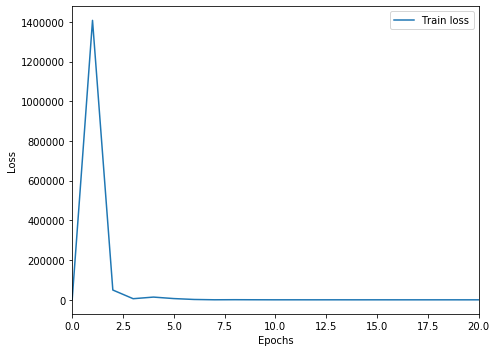

In [33]:
plt.figure(figsize=(7,5))
plt.plot(loss_hist, label='Train loss')
plt.xlabel('Epochs')
plt.ylabel('Loss');
plt.xlim(0, 0 + 20)
plt.legend()
plt.tight_layout()
plt.savefig('{}/loss.png'.format(weights_dir))

---
## Model Inference

In [ ]:
song = d_train[120]
print('Song index: ', song['song_index'])
print('Song name: ', song['song_name'])

sum_audio = np.zeros_like(song['mixture_audio'])

for track in d_test._tracklist:
    if track != 'mixture':
        sum_audio += song['{}_audio'.format(track)]

ipd.Audio(sum_audio, rate=44100)

In [ ]:
ipd.Audio(song['mixture_audio'], rate=44100)

In [40]:
features = torch.Tensor(song['train_features'][np.newaxis, :])
masked, masks = model(features.to(device))

res = masked.to('cpu').detach().numpy()
print(res[0])

[[15.8628845 22.376766  23.518484  ... 23.78349   21.462868  13.89432  ]
 [15.945997  22.581207  23.749249  ... 24.028042  21.58822   13.952108 ]
 [15.936067  22.59636   23.694607  ... 24.117714  21.721004  13.993716 ]
 ...
 [15.562176  22.166578  23.257336  ... 23.721416  21.404976  13.750998 ]
 [15.562176  22.166578  23.257336  ... 23.721416  21.404976  13.750998 ]
 [15.562176  22.166578  23.257336  ... 23.721416  21.404976  13.750998 ]]


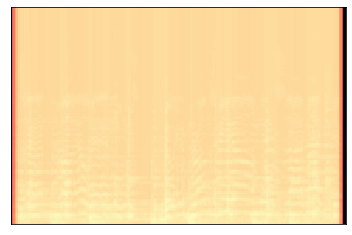

In [41]:
librosa.display.specshow(res[0])

---
### Mixing the full song

In [7]:
# song_path = os.path.join(base_path, 'test/The Easton Ellises - Falcon 69')
song_path = os.path.join(base_path, 'train/Aimee Norwich - Child')

loaded_tracks = {}

for track in d_train.get_tracklist():
    track_path = os.path.join(song_path, '{}.wav'.format(track))
    print('Loading {}'.format(track))
    loaded_tracks[track], _ = librosa.load(track_path, sr=44100)

Loading bass
Loading drums
Loading vocals
Loading other
Loading mixture


In [ ]:
# ground truth
ipd.Audio(loaded_tracks['mixture'], rate=44100)

In [ ]:
# summed tracks, no mix
sum_audio = np.zeros_like(loaded_tracks['mixture'])

for track in d_train.get_tracklist():
    if track != 'mixture':
        print('Summing {}'.format(track))
        sum_audio += loaded_tracks['{}'.format(track)]

ipd.Audio(sum_audio, rate=44100)

In [ ]:
# model result
mixed_song = mix_song(d_train, model, loaded_tracks, dummy_masks=False)
ipd.Audio(mixed_song, rate=44100)